In [1]:
!pip install torch torchvision

  Using cached torch-2.7.1-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached torchvision-0.22.1-cp312-cp312-win_amd64.whl.metadata (6.1 kB)
Using cached torch-2.7.1-cp312-cp312-win_amd64.whl (216.1 MB)
Using cached torchvision-0.22.1-cp312-cp312-win_amd64.whl (1.7 MB)


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [12]:
# Load the preprocessed data
df = pd.read_csv("freedom_cleaned.csv")

In [14]:
# Features and labels
features = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
X = df[features].values
y = df['FreedomStatus_encoded'].values
num_classes = len(np.unique(y))

In [18]:
# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

latent_dim = 100
feature_dim = X.shape[1]

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, feature_dim),
            nn.Tanh()
        )

    def forward(self, z, labels):
        c = self.label_emb(labels)
        x = torch.cat([z, c], dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2)
        )
        self.adv_layer = nn.Linear(64, 1)
        self.aux_layer = nn.Linear(64, num_classes)

    def forward(self, x):
        features = self.model(x)
        validity = self.adv_layer(features)
        label = self.aux_layer(features)
        return validity, label


In [20]:
# Initialize models
generator = Generator()
discriminator = Discriminator()

In [22]:
# Losses
adversarial_loss = nn.BCEWithLogitsLoss()
auxiliary_loss = nn.CrossEntropyLoss()

In [24]:
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

In [26]:
# Training loop
n_epochs = 200
for epoch in range(n_epochs):
    for real_samples, labels in dataloader:
        batch_size = real_samples.size(0)

        # Adversarial ground truths
        valid = torch.ones(batch_size, 1)
        fake = torch.zeros(batch_size, 1)

        # ---------------------
        #  Train Generator
        # ---------------------
        z = torch.randn(batch_size, latent_dim)
        gen_labels = torch.randint(0, num_classes, (batch_size,))
        gen_samples = generator(z, gen_labels)

        validity, pred_label = discriminator(gen_samples)
        g_loss = adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        real_pred, real_aux = discriminator(real_samples)
        d_real_loss = adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)

        fake_pred, fake_aux = discriminator(gen_samples.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)

        d_loss = 0.5 * (d_real_loss + d_fake_loss)

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

    if epoch % 20 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch}/{n_epochs} | D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f}")

# Generate and view samples
z = torch.randn(100, latent_dim)
y_sample = torch.tensor([0]*30 + [1]*30 + [2]*40)
with torch.no_grad():
    generated = generator(z, y_sample).numpy()


Epoch 0/200 | D loss: 1.3152 | G loss: 1.8433
Epoch 20/200 | D loss: 0.8927 | G loss: 4.3698
Epoch 40/200 | D loss: 0.3967 | G loss: 4.4620
Epoch 60/200 | D loss: 0.1144 | G loss: 4.6043
Epoch 80/200 | D loss: 0.0635 | G loss: 4.8375
Epoch 100/200 | D loss: 0.0543 | G loss: 4.8092
Epoch 120/200 | D loss: 0.3006 | G loss: 5.0474
Epoch 140/200 | D loss: 0.0547 | G loss: 5.1813
Epoch 160/200 | D loss: 0.0351 | G loss: 5.0619
Epoch 180/200 | D loss: 0.0337 | G loss: 5.2546
Epoch 199/200 | D loss: 0.0679 | G loss: 5.1649


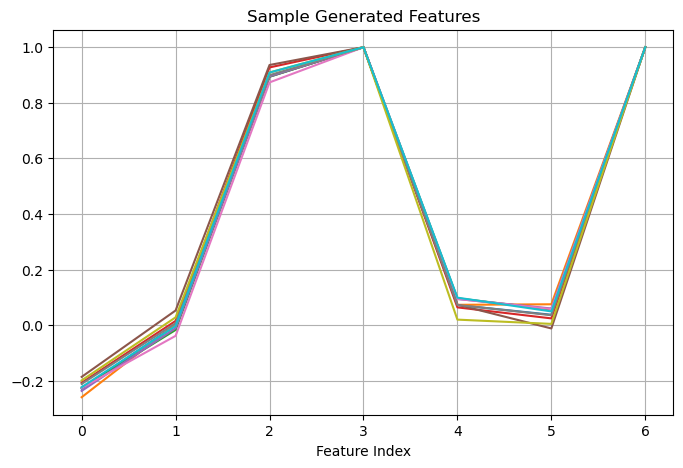

In [28]:
# Plot a few generated samples
plt.figure(figsize=(8, 5))
plt.plot(generated[:10].T)
plt.title("Sample Generated Features")
plt.xlabel("Feature Index")
plt.grid(True)
plt.show()

In [30]:
torch.save(generator.state_dict(), "generator.pth")